# Development

In [1]:
# setup cell
# settings
storm = "batsirai"
region = "tsiribihina"
nsubregions = 1
subregion = 0

import math
from os.path import join, exists
from os import remove
import warnings
import time

# standard scientific
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
# ! pip install zarr

# gee
import ee

# raster stuff
import dask.distributed
# import pystac_client
import rioxarray  # noqa: F401

# import contextily
import rasterio
import shapely.geometry
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from ast import literal_eval
from os.path import join
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, shape

import viz_utils
import data_utils
from event import Event, pwater_thresh
from importlib import reload

import folium

def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

plt.rcParams['font.family'] = 'Arial'

def get_gdf_centroid(gdf):
    lon, lat = gdf.dissolve().centroid[0].xy
    return lat[0], lon[0]

# set up env
bd = join("..", "data")
wd = join(bd, 'storm_events', f"{storm}_{region}")

# load event GeoDataFrame (as when getting data)
event = Event(storm, region, nsubregions, wd, bd)
event.make_grids()
self = event
# event.get_all_features(subregion)

In [2]:
feature_gdf = event.get_feature_gdf(subregion)

In [3]:
event.get_floodfrac(subregion, recalculate=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:01<00:00, 2925.80it/s]
batsirai_tsiribihina_0: error adding extra flood info:
"['det_method', 'obj_desc'] not in index"
Creating empty fields


<AxesSubplot: >

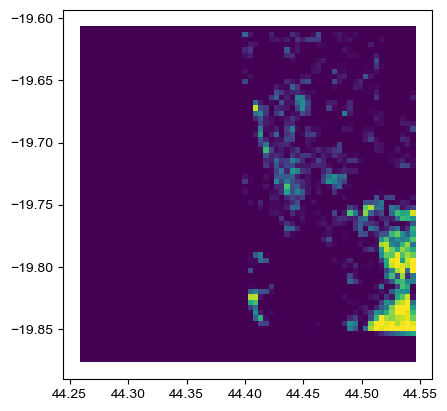

In [5]:
feature_gdf = event.get_feature_gdf(subregion)
feature_gdf.plot('floodfrac')

<AxesSubplot: >

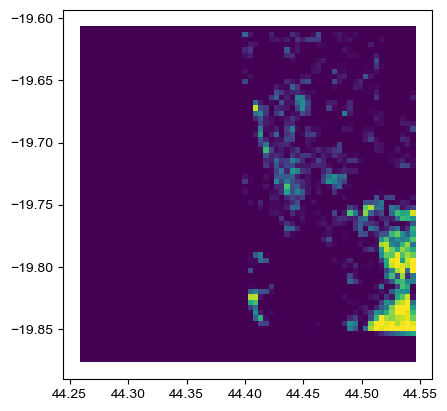

In [4]:
feature_gdf = event.get_feature_gdf(subregion)
feature_gdf.plot('floodfrac')

<AxesSubplot: >

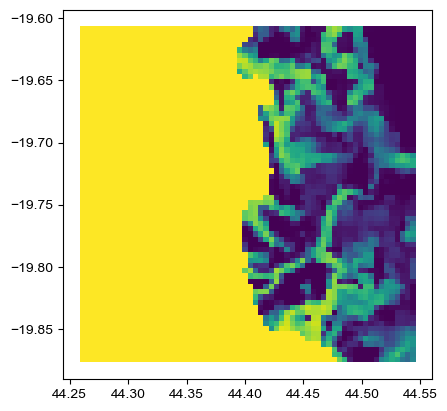

In [3]:
feature_gdf.plot('jrc_permwa')

## Distance and slope to permanent water / coast

In [ ]:
event.get_gdf(subregion)
event.get_all_features(subregion, recalculate_features=True, feature_list=['permwater'])
feature_gdf = event.feature_gdf[subregion]

In [ ]:
feature_gdf.plot('jrc_permwa')

In [9]:
feature_gdf = get_permwater(event, subregion, recalculate=True)

> /var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_22727/2007643262.py(39)get_permwater()
     37             # fill in any missing data in ocean (making all ocean have 100% occurence)
     38             import pdb; pdb.set_trace()
---> 39             ocean = gpd.read_parquet(join(self.bd, 'openstreetmap', 'water-osm.parquet')).to_crs(4326).clip(mask=aoi_lonlat)
     40             import pdb; pdb.set_trace()
     41             assert feature_gdf.crs == ocean.crs, "gdfs have different coordinated reference systems."

ipdb> c


/Users/alison/miniconda3/envs/hybridmodels/lib/python3.10/site-packages/pygeos/set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


> /var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_22727/2007643262.py(41)get_permwater()
     39             ocean = gpd.read_parquet(join(self.bd, 'openstreetmap', 'water-osm.parquet')).to_crs(4326).clip(mask=aoi_lonlat)
     40             import pdb; pdb.set_trace()
---> 41             assert feature_gdf.crs == ocean.crs, "gdfs have different coordinated reference systems."
     42             with warnings.catch_warnings():
     43                 warnings.filterwarnings("ignore", category=RuntimeWarning)

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


<AxesSubplot: >

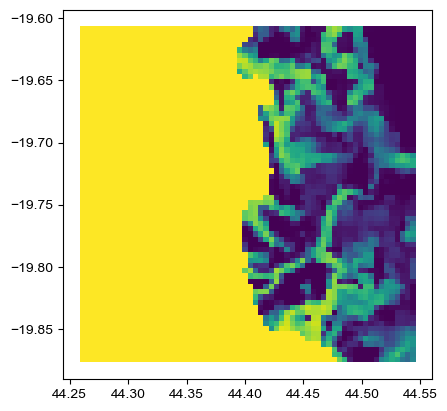

In [10]:
feature_gdf.plot('jrc_permwa')

<AxesSubplot: >

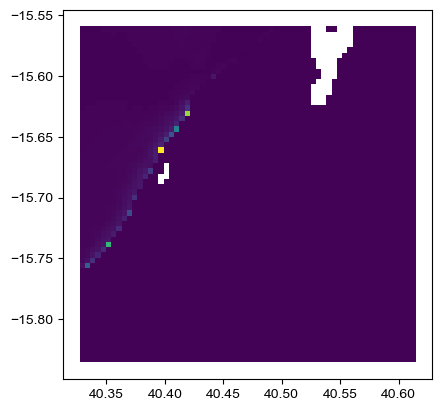

In [4]:
feature_gdf.plot('slope_coast')

##  Anomaly (beta)
### Soil temperature

In [17]:
def spatial_mean(feat, aoi_ee, gridsize):
    
    spatial_mean = feat.reduceRegions(aoi_ee,
                                      ee.Reducer.mean(),
                                      crs="EPSG:4326",
                                      scale=gridsize)
    spatial_mean = spatial_mean.getInfo()['features'][0]['properties']['mean']
    feat = feat.unmask(spatial_mean)
    
    return feat


def get_feat(collection, start, end, aoi_ee, gridsize, unmask=0):
    """Get the feature from GEE and unmask using selected method."""
    
    feat = ee.Image(collection
                    .filterBounds(aoi_ee)
                    .filterDate(start, end)
                    .sort('system:time_start', False)
                    .mean()
                    .clip(aoi_ee))
    
    if isinstance(unmask, Number):
        feat = feat.unmask(unmask)
    elif callable(unmask):
        feat = unmask(feat, aoi_ee, gridsize)
        
    return feat

    

def get_anomaly(collection, start, end, baseyear, aoi_ee, gridsize, unmask):
    """Get anomaly for any collection.
    
    Parameters:
    -----------
    collection : ee.ImageCollection
        Must have single band selected.
    start : ee.Date
    end : ee.Date
    baseyear : int
    
    
    >> feat, anomaly = get_anomaly(collection, start, end, baseyear, aoi_ee, gridsize)
    """
    years = ee.List.sequence(ee.Number(baseyear), start.get('year'))

    def window_average(year):
        yeardiff = ee.Number.parse(start.get('year').format()).getInfo() - baseyear       
        window_start = start.advance(-yeardiff, 'years')
        window_end = end.advance(-yeardiff, 'years')

        mean = ee.Image(collection
                          .filterBounds(aoi_ee)
                          .filterDate(window_start, window_end)
                          .mean()
                          .clip(aoi_ee))
        return mean.set('year', year)

    # get temporal reference value
    temporal_means = ee.ImageCollection.fromImages(years.map(window_average))
    temporal_mean = ee.Image(temporal_means.mean())
    spatiotemporal_mean = temporal_mean.reduceRegions(aoi_ee,
                                                  ee.Reducer.mean(),
                                                  crs="EPSG:4326",
                                                  scale=gridsize)
    spatiotemporal_mean =  spatiotemporal_mean.getInfo()['features'][0]['properties']['mean']
    temporal_mean = temporal_mean.unmask(spatiotemporal_mean)

    # get image for present time window
    feat = get_feat(collection, start, end, aoi_ee, gridsize, unmask=unmask)
    anomaly = feat.subtract(temporal_mean)
    
    return feat, anomaly


def get_soiltemp(self, subregion, recalculate=False, advance=1):
    """ERA5 Land Monthly Averaged ECMWF Climate Reanalysis.

    Dataset coverage: 1981-01-01T00:00:00Z – 2022-08-01T00:00:00

    Parameters:
    -----------
    advance : int (default=1)
        Number of months before storm start date to begin collecting data.
    """

    if self.feature_gdf[subregion] is None: self.get_gdf(subregion)

    if "soil_temperature_level_1" not in self.feature_gdf[subregion] or recalculate:
        feature_gdf = self.feature_gdf[subregion]

        # set up Google Earth Engine for subregion
        if self.connected_to_gee != subregion: self.start_gee(subregion)
        aoi_ee = self.aoi_ee[subregion]
        grid_ee = self.grid_ee[subregion]

        # which features from ERA5 Daily Aggregates to use
        feature_names = ['soiltemp1', 'soiltemp2']
        features = ['soil_temperature_level_1', 'soil_temperature_level_2']

        for feature, feature_name in zip(features, feature_names):
            self.logger.info(f"Calculating ERA5 {feature_name}...")
            try:
                collection = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").select(feature)
                start = ee.Date(self.startdate).advance(-advance, 'month')
                end = ee.Date.parse('YYYY-MM-dd HH:mm', self.acquisition_time)
                baseyear = 1981
                feat, anomaly = get_anomaly(collection, start, end, baseyear, aoi_ee, self.gridsize, spatial_mean)

                # Add reducer output to the Features in the collection.
                mean_feat = feat.reduceRegions(collection=grid_ee,
                                               reducer=ee.Reducer.mean(),
                                               scale=self.gridsize,
                                               crs="EPSG:4326")
                feat_list = mean_feat.aggregate_array('mean').getInfo()
                feature_gdf[feature_name] = feat_list


                # Add anomaly reducer output to Features
                mean_anomaly = anomaly.reduceRegions(collection=grid_ee,
                                               reducer=ee.Reducer.mean(),
                                               scale=self.gridsize,
                                               crs="EPSG:4326")
                anomaly_list = mean_anomaly.aggregate_array('mean').getInfo()
                feature_gdf[f'{feature_name}_anom'] = anomaly_list


            except Exception as e:
                self.logger.warning(f"Error for {feature_name} for {self.storm}, {self.region}, {subregion}:"\
                                    f"{e}\nCreating empty field.")
                feature_gdf[feature_name] = [""] * len(feature_gdf)
                feature_gdf[f'{feature_name}_anom'] = [""] * len(feature_gdf)


        # save output
#         self.feature_gdf[subregion] = feature_gdf
#         self.save_gdf(subregion)
        
        return feature_gdf  # dev only

<AxesSubplot: >

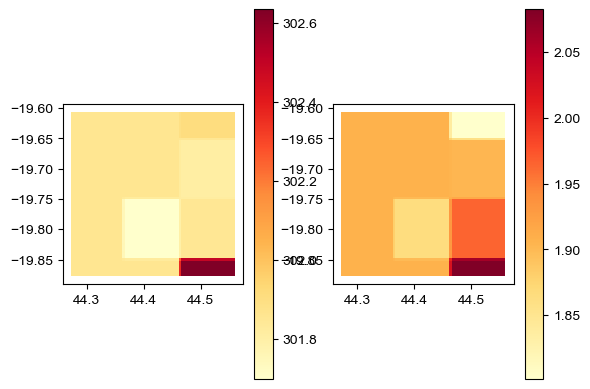

In [19]:
feat = get_soiltemp(event, subregion)

fig, ax = plt.subplots(1, 2)

feat.plot('soiltemp1', cmap="YlOrRd", ax=ax[0], legend=True)
feat.plot('soiltemp1_anom', cmap="YlOrRd", ax=ax[1], legend=True)

### EVI anomaly

In [21]:
    def get_evi(self, subregion, recalculate=False, advance=2):
        """EVI (reprojected and masked from mangroves)

        Dataset coverage: 2000-02-18T00:00:00Z–2022-12-19T00:00:00

        Parameters:
        ----------
        advance : int (default=2)
            Number of months before storm start date to average evi from.
        """

        if self.feature_gdf[subregion] is None: self.get_gdf(subregion)

        if "evi" not in self.feature_gdf[subregion] or recalculate:
            self.logger.info("Calculating EVI...")
            feature_gdf = self.feature_gdf[subregion]

            try:                
                # set up Google Earth Engine for subregion
                if self.connected_to_gee != subregion: self.start_gee(subregion)
                aoi_ee = self.aoi_ee[subregion]
                grid_ee = self.grid_ee[subregion]

                # timeframe and collection
                collection = ee.ImageCollection("MODIS/006/MOD13Q1").select('EVI')
                start = ee.Date(self.startdate).advance(-advance, 'month')
                end = ee.Date.parse('YYYY-MM-dd HH:mm', self.acquisition_time)
                baseyear = 2000
                evi, anomaly = get_anomaly(collection, start, end, baseyear, aoi_ee, self.gridsize, 0)

                # calculate mean over feature collection
                mean_evi = evi.reduceRegions(collection=grid_ee,
                                               reducer=ee.Reducer.mean(), scale=self.gridsize)

                evi_list = mean_evi.aggregate_array('mean').getInfo()
                feature_gdf["evi"] = evi_list

                # Add anomaly reducer output to Features
                mean_anomaly = anomaly.reduceRegions(collection=grid_ee,
                                               reducer=ee.Reducer.mean(),
                                               scale=self.gridsize,
                                               crs="EPSG:4326")
                anomaly_list = mean_anomaly.aggregate_array('mean').getInfo()
                feature_gdf[f'evi_anom'] = anomaly_list

            except Exception as e:
                self.logger.warning(f"Error for evi for {self.storm}, {self.region}, {subregion}:"\
                                    f"{e}\nCreating empty field.")
                feature_gdf["evi"] = [""] * len(feature_gdf)
                feature_gdf["evi_anom"] = [""] * len(feature_gdf)

            # save output
            self.feature_gdf[subregion] = feature_gdf
            self.save_gdf(subregion)
            return feature_gdf

<AxesSubplot: >

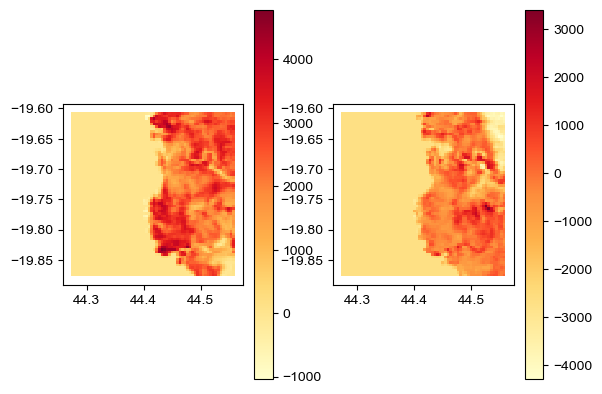

In [22]:
feat = get_evi(event, subregion)

fig, ax = plt.subplots(1, 2)

feat.plot('evi', cmap="YlOrRd", ax=ax[0], legend=True)
feat.plot('evi_anom', cmap="YlOrRd", ax=ax[1], legend=True)

## Soil temperature

In [95]:
# Helper functions
from numbers import Number

def spatial_mean(feat, aoi_ee, gridsize):
    """Function to use with unmasking."""
    spatial_mean = feat.reduceRegions(aoi_ee,
                                      ee.Reducer.mean(),
                                      crs="EPSG:4326",
                                      scale=gridsize)
    spatial_mean = spatial_mean.getInfo()['features'][0]['properties']['mean']
    feat = feat.unmask(spatial_mean)
    
    return feat, spatial_mean


def get_feat(collection, start, end, aoi_ee, gridsize, unmask=0):
    """Get the feature from GEE and unmask using selected method.
    
    Parameters:
    -----------
    unmask : number or callable (default=0)
        If a number is supplied NaN values are replaced with this number. If a callable
        this function is used to interpolate the misisng values. See spatial_mean function
        for an example.
    """
    feat = ee.Image(collection
                    .filterBounds(aoi_ee)
                    .filterDate(start, end)
                    .sort('system:time_start', False)
                    .mean()
                    .clip(aoi_ee))

    if isinstance(unmask, Number):
        feat = feat.unmask(unmask)
    elif callable(unmask):
        feat, val = unmask(feat, aoi_ee, gridsize)
    
    return feat


def get_anomaly(collection, start, end, baseyear, aoi_ee, gridsize, unmask):
    """Get anomaly for any collection.
    

    Parameters:
    -----------
    collection : ee.ImageCollection
        Must have single band selected.
    start : ee.Date
    end : ee.Date
    baseyear : int


    >> feat, anomaly = get_anomaly(collection, start, end, baseyear, aoi_ee, gridsize)
    """
    years = ee.List.sequence(ee.Number(baseyear), start.get('year'))

    def window_average(year):
        yeardiff = ee.Number.parse(start.get('year').format()).getInfo() - baseyear
        window_start = start.advance(-yeardiff, 'years')
        window_end = end.advance(-yeardiff, 'years')

        mean = ee.Image(collection
                          .filterBounds(aoi_ee)
                          .filterDate(window_start, window_end)
                          .mean()
                          .clip(aoi_ee))
        
        return mean.set('year', year)

    # get temporal reference value
    temporal_means = ee.ImageCollection.fromImages(years.map(window_average))
    temporal_mean = ee.Image(temporal_means.mean())

    import pdb; pdb.set_trace()
    spatiotemporal_mean = temporal_mean.reduceRegions(aoi_ee,
                                                  ee.Reducer.mean(),
                                                  crs="EPSG:4326",
                                                  scale=gridsize)
    spatiotemporal_mean =  spatiotemporal_mean.getInfo()['features'][0]['properties']['mean']
    temporal_mean = temporal_mean.unmask(spatiotemporal_mean)


    # get image for present time window
    feat = get_feat(collection, start, end, aoi_ee, gridsize, unmask=unmask)
    anomaly = feat.subtract(temporal_mean)

    return feat, anomaly
  
    
def get_soiltemp(self, subregion, recalculate=False, advance=1):
    """ERA5 Land Monthly Averaged ECMWF Climate Reanalysis.

    Dataset coverage: 1981-01-01T00:00:00Z – 2022-08-01T00:00:00

    Parameters:
    -----------
    advance : int (default=1)
        Number of months before storm start date to begin collecting data.
    """

    if self.feature_gdf[subregion] is None: self.get_gdf(subregion)

    if "soil_temperature_level_1" not in self.feature_gdf[subregion] or recalculate:
        feature_gdf = self.feature_gdf[subregion]

        # set up Google Earth Engine for subregion
        if self.connected_to_gee != subregion: self.start_gee(subregion)
        aoi_ee = self.aoi_ee[subregion]
        grid_ee = self.grid_ee[subregion]

        # which features from ERA5 Daily Aggregates to use
        feature_names = ['soiltemp1', 'soiltemp2']
        features = ['soil_temperature_level_1', 'soil_temperature_level_2']

        for feature, feature_name in zip(features, feature_names):
            self.logger.info(f"Calculating ERA5 {feature_name}...")
#             try:

            collection = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").select(feature)
            start = ee.Date(self.startdate).advance(-advance, 'month')
            end = ee.Date.parse('YYYY-MM-dd HH:mm', self.acquisition_time)
            baseyear = 1981
            
            feat, anomaly = get_anomaly(collection, start, end, baseyear, aoi_ee, self.gridsize, spatial_mean)

            # Add reducer output to the Features in the collection.
            mean_feat = feat.reduceRegions(collection=grid_ee,
                                           reducer=ee.Reducer.mean(),
                                           scale=self.gridsize,
                                           crs="EPSG:4326")
            
            # feat_list = mean_feat.aggregate_array('mean').getInfo()
            feat_list = mean_feat.getInfo()
            feat_list = [feat['properties'].get('mean', np.nan) for feat in feat_list['features']]
            feature_gdf[feature_name] = feat_list


            # Add anomaly reducer output to Features
            mean_anomaly = anomaly.reduceRegions(collection=grid_ee,
                                           reducer=ee.Reducer.mean(),
                                           scale=self.gridsize,
                                           crs="EPSG:4326")
            
            # anomaly_list = mean_anomaly.aggregate_array('mean').getInfo()
            anomaly_list = mean_anomaly.getInfo()
            anomaly_list = [feat['properties'].get('mean', np.nan) for feat in anomaly_list['features']]
            feature_gdf[f'{feature_name}_anom'] = anomaly_list


            return feat


#             except Exception as e:
#                 self.logger.warning(f"Error for {feature_name} for {self.storm}, {self.region}, {subregion}:"\
#                                     f"{e}\nCreating empty field.")
#                 feature_gdf[feature_name] = [np.nan] * len(feature_gdf)
#                 feature_gdf[f'{feature_name}_anom'] = [np.nan] * len(feature_gdf)

#                 return None


        # save output
        self.feature_gdf[subregion] = feature_gdf
        self.save_gdf(subregion)

In [ ]:
feat = get_soiltemp(event, subregion)
# feat = feat.unmask(0)

> /var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_10719/2865477536.py(76)get_anomaly()
     74 
     75     import pdb; pdb.set_trace()
---> 76     spatiotemporal_mean = temporal_mean.reduceRegions(aoi_ee,
     77                                                   ee.Reducer.mean(),
     78                                                   crs="EPSG:4326",

ipdb> temporal_mean.getInfo()
{'type': 'Image', 'bands': [{'id': 'soil_temperature_level_1', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


In [94]:
feat['soiltemp2']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4091   NaN
4092   NaN
4093   NaN
4094   NaN
4095   NaN
Name: soiltemp2, Length: 4096, dtype: float64

In [89]:


lat, lon = get_gdf_centroid(event.feature_gdf[subregion])

/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_10719/1415295686.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon, lat = gdf.dissolve().centroid[0].xy


In [90]:
viz = {'min': 250.0, 'max': 320.0,
       'palette': ["#000080","#0000D9","#4000FF","#8000FF","#0080FF","#00FFFF",
                   "#00FF80","#80FF00","#DAFF00","#FFFF00","#FFF500","#FFDA00",
                   "#FFB000","#FFA400","#FF4F00","#FF2500","#FF0A00","#FF00FF",
                  ]
}


m = folium.Map(location=[lat, lon], zoom_start=10)
m.add_ee_layer(feat, viz, 'Soil Temperature')

m

## Winds again

In [134]:
from wind_utils import *
from datetime import datetime, timedelta


def process_ibtracs(ibtracs_df, storm):
    """
    Process IBTrACS wind and radius of max wind data.

    Note: when using WMO winds uses USA RMW for radius of max winds.
    """

    logger = logging.getLogger(f"data_collection.{storm}")

    # set up geometry
    print(f"1: {len(ibtracs_df)}")
    ibtracs_gdf = ibtracs_df
    for col in ["LAT", "LON"]: ibtracs_gdf[col] = pd.to_numeric(ibtracs_gdf[col])
    ibtracs_gdf["geometry"] = gpd.points_from_xy(ibtracs_gdf.LON, ibtracs_gdf.LAT)
    ibtracs_gdf = ibtracs_gdf.set_crs("EPSG:4326")
    assert not ibtracs_gdf.BASIN.isna().any(), "BASIN has NaN values"
    print(f"2: {len(ibtracs_gdf)}")
    # grab most-recorded wind speed if WMO not available
    if ibtracs_gdf.WMO_WIND.isna().all():
        logger.info("Not using WMO Winds.")
        wind_col = ibtracs_gdf[WIND_COLS].notna().sum().idxmax()
        agency = wind_col.split("_")[0]
        logger.info(f"Agency: {agency}")
        pressure_col = f"{agency}_PRES"
        rmw_col = f"{agency}_RMW"
        
        # rescale wind speed to MSW10
        scale, shift = IBTRACS_AGENCY_10MIN_WIND_FACTOR[agency.lower()]
        ibtracs_gdf[f'{agency}_wind'.upper()] = pd.to_numeric(ibtracs_gdf[f'{agency}_wind'.upper()])
        ibtracs_gdf[f'{agency}_wind'.upper()] *= scale
        ibtracs_gdf[f'{agency}_wind'.upper()] += shift
        print(f"3a: {len(ibtracs_gdf)}")
    else:
        logger.info("Using WMO Winds.")
        wind_col = "WMO_WIND"
        pressure_col = "WMO_PRES"
        agency = ibtracs_gdf["WMO_AGENCY"].mode()[0]
        logger.info(f"Agency: {agency}")
        rmw_col = f"USA_RMW"  # possibly use different later

        # rescale wind speed to MSW10
        scale, shift = IBTRACS_AGENCY_10MIN_WIND_FACTOR[agency]
        ibtracs_gdf[wind_col] = pd.to_numeric(ibtracs_gdf[wind_col])
        ibtracs_gdf[wind_col] *= scale
        ibtracs_gdf[wind_col] += shift
        print(f"3b: {len(ibtracs_gdf)}")

    logger.info(f"RMW column: {rmw_col}, wind column: {wind_col}, pressure column {pressure_col}")
    logger.info(f"Scale: {scale}")
    logger.info(f"Shift: {shift}")

    # fix timestamps formatting
    newtimes = []
    for time in ibtracs_gdf["ISO_TIME"]:
        if len(time) > 8:
            date = time[:10]
            newtimes.append(time)
        else:
            newtime = f"{date} {time}"
            newtimes.append(newtime)

    ibtracs_gdf['ISO_TIME'] = newtimes
    ibtracs_gdf = ibtracs_gdf.dropna(subset=wind_col).reset_index()
    return ibtracs_gdf, wind_col, pressure_col, rmw_col


def get_wind_field(ibtracs_gdf, feature_gdf, units_df, wind_col, pressure_col, rmw_col, acquisition_time):
    """
    Calculate wind fields from IBTrACS data for a grid GeoDataFrame.
    """

    # get centroids
    centroids = feature_gdf.to_crs("EPSG:3857").centroid.to_crs("EPSG:4326")
    wind_tracks = ibtracs_gdf.geometry
    lats = [*wind_tracks.y]
    lons = [*wind_tracks.x]

    # haversine distances
    h_distances = []
    for centroid in centroids:
        h_distances.append(haversine(centroid.x, centroid.y, lons, lats))
    h_distances = np.array(h_distances)
    assert len(ibtracs_gdf) == h_distances.shape[1],\
        "Number of haversine distances calculates did not match number of centroids"

    # define interval of [-5, 0] days before acquisition time to get wind for
    acquisition_dt = datetime.strptime(acquisition_time, '%Y-%m-%d %H:%M')
    start_dt = start = acquisition_dt - timedelta(5)

    # calculate wind field for each time stamp
    timestamps = []
    for time in range(len(ibtracs_gdf)):

        # only process winds up to five days before acquisition date
        iso_time = ibtracs_gdf['ISO_TIME'][time]
        iso_dt = datetime.strptime(iso_time, '%Y-%m-%d %H:%M:%S')
        if start_dt < iso_dt < acquisition_dt:
            # inputs for holland function
            h_dists = [x[time] for x in h_distances]
            basin = ibtracs_gdf["BASIN"][time]
            pressure_env = BASIN_ENV_PRESSURE[basin]
            pressure = float(ibtracs_gdf[pressure_col][time])
            lat = float(ibtracs_gdf["LAT"][time])

            if abs(pressure_env - pressure) > 0:
                # radius of maximum winds in km
                if units_df[rmw_col][0] == "nmile":
                    r = nmile_to_km(float(ibtracs_gdf[rmw_col][time]))
                else:
                    r = float(ibtracs_gdf[rmw_col][time])

                # maximum wind speed in mps
                if units_df[wind_col][0] == "kts":
                    wind = knots_to_mps(float(ibtracs_gdf[wind_col][time]))
                else:
                    wind = ibtracs_gdf[wind_col][time]

                # calculate wind field
                wind_field = []
                for distance in h_dists:
                    wind_speed = holland_wind_field(r, wind, pressure, pressure_env, distance, lat)
                    wind_field.append(wind_speed)

                # reformat time string
                date, time = iso_time.split(" ")
                date = date[5:]
                time = time[:2]

                # if non-neglible wind, append to dataframe
                if sum(wind_field) > 0:
                    feature_gdf[f"wnd{date}_{time}"] = wind_field
            else:
                logging.warning(f"No pressure drop for time {time}, skipping wind speed calculation.")

    return feature_gdf

def get_wind_fields(self, subregion, recalculate=False):
    """Get wind fields from IBTrACs data using Holland (1980) method.

    Adds wind field columns where wind is nonzero to feature GeoDataFrame and
    average over all these wind field columns (i.e., over storm duration)
    """
    if self.feature_gdf[subregion] is None: self.get_gdf(subregion)

    if not any("wnd" in col for col in self.feature_gdf[subregion].columns) or recalculate:
        self.logger.info("Calculating wind speeds...")
        feature_gdf = self.feature_gdf[subregion]

        try:
            # load and process IBTrACs data
            if self.year > 2017:
                ibtracs_gdf = gpd.read_file(join(self.wd, "ibtracs_last3years.csv"))[1:].replace(" ", np.nan)
                ibtracs_gdf = ibtracs_gdf[ibtracs_gdf.NAME == self.storm.upper()]
                units_df = pd.read_csv(join(self.wd, "ibtracs_last3years.csv"), dtype=str, header=0)[0:1]
            else:
                ibtracs_gdf = gpd.read_file(join(self.wd, "ibtracs_since1980.csv"))[1:].replace(" ", np.nan)
                ibtracs_gdf = ibtracs_gdf[ibtracs_gdf.NAME == self.storm.upper()]
                units_df = pd.read_csv(join(self.wd, "ibtracs_since1980.csv"), dtype=str, header=0)[0:1]
            
            # process IBTrACS data
            import pdb; pdb.set_trace()
            ibtracs_gdf, wind_col, pressure_col, rmw_col = process_ibtracs(ibtracs_gdf, self.storm)
            feature_gdf = get_wind_field(ibtracs_gdf, feature_gdf, units_df, wind_col, pressure_col, rmw_col, self.acquisition_time)
            import pdb; pdb.set_trace()
            
            # save average wind field
            timemask = ["wnd" in col for col in feature_gdf.columns]
            timestamps = feature_gdf.columns[timemask]
            feature_gdf["wind_avg"] = feature_gdf[timestamps].mean(axis=1)

        except Exception as e:
            self.logger.warning(f"Error for wind fields for {self.storm}, {self.region}, {subregion}:"\
                                f"{e}\nCreating empty field.")
            feature_gdf["wind_avg"] = [""] * len(feature_gdf)
            
            
        return feature_gdf

#         self.feature_gdf[subregion] = feature_gdf
#         self.save_gdf(subregion)

In [ ]:
_ = get_wind_fields(event, subregion, recalculate=True)

> /var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_68138/1500773833.py(166)get_wind_fields()
    164             # process IBTrACS data
    165             import pdb; pdb.set_trace()
--> 166             ibtracs_gdf, wind_col, pressure_col, rmw_col = process_ibtracs(ibtracs_gdf, self.storm)
    167             feature_gdf = get_wind_field(ibtracs_gdf, feature_gdf, units_df, wind_col, pressure_col, rmw_col, self.acquisition_time)
    168             import pdb; pdb.set_trace()

ipdb> ibtracs_gdf
                 SID SEASON NUMBER BASIN SUBBASIN   NAME             ISO_TIME  \
17933  2022067S16050   2022     16    SI       MM  GOMBE  2022-03-08 00:00:00   
17934  2022067S16050   2022     16    SI       MM  GOMBE  2022-03-08 03:00:00   
17935  2022067S16050   2022     16    SI       MM  GOMBE  2022-03-08 06:00:00   
17936  2022067S16050   2022     16    SI       MM  GOMBE  2022-03-08 09:00:00   
17937  2022067S16050   2022     16    SI       MM  GOMBE  2022-03-08 12:00:00   
1793

ipdb> ibtracs_gdf[['NAME', 'ISO_TIME']]
        NAME             ISO_TIME
17933  GOMBE  2022-03-08 00:00:00
17934  GOMBE  2022-03-08 03:00:00
17935  GOMBE  2022-03-08 06:00:00
17936  GOMBE  2022-03-08 09:00:00
17937  GOMBE  2022-03-08 12:00:00
17938  GOMBE  2022-03-08 15:00:00
17939  GOMBE  2022-03-08 18:00:00
17940  GOMBE  2022-03-08 21:00:00
17941  GOMBE  2022-03-09 00:00:00
17942  GOMBE  2022-03-09 03:00:00
17943  GOMBE  2022-03-09 06:00:00
17944  GOMBE  2022-03-09 09:00:00
17945  GOMBE  2022-03-09 12:00:00
17946  GOMBE  2022-03-09 15:00:00
17947  GOMBE  2022-03-09 18:00:00
17948  GOMBE  2022-03-09 21:00:00
17949  GOMBE  2022-03-10 00:00:00
17950  GOMBE  2022-03-10 03:00:00
17951  GOMBE  2022-03-10 06:00:00
17952  GOMBE  2022-03-10 09:00:00
17953  GOMBE  2022-03-10 12:00:00
17954  GOMBE  2022-03-10 15:00:00
17955  GOMBE  2022-03-10 18:00:00
17956  GOMBE  2022-03-10 21:00:00
17957  GOMBE  2022-03-11 00:00:00
17958  GOMBE  2022-03-11 03:00:00
17959  GOMBE  2022-03-11 06:00:00
17960  G

> /var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_68138/1500773833.py(171)get_wind_fields()
    169 
    170             # save average wind field
--> 171             timemask = ["wnd" in col for col in feature_gdf.columns]
    172             timestamps = feature_gdf.columns[timemask]
    173             feature_gdf["wind_avg"] = feature_gdf[timestamps].mean(axis=1)

ipdb> ibtracs_gdf[['NAME', 'ISO_TIME']]
     NAME             ISO_TIME
0   GOMBE  2022-03-08 00:00:00
1   GOMBE  2022-03-08 03:00:00
2   GOMBE  2022-03-08 06:00:00
3   GOMBE  2022-03-08 09:00:00
4   GOMBE  2022-03-08 12:00:00
5   GOMBE  2022-03-08 15:00:00
6   GOMBE  2022-03-08 18:00:00
7   GOMBE  2022-03-08 21:00:00
8   GOMBE  2022-03-09 00:00:00
9   GOMBE  2022-03-09 03:00:00
10  GOMBE  2022-03-09 06:00:00
11  GOMBE  2022-03-09 09:00:00
12  GOMBE  2022-03-09 12:00:00
13  GOMBE  2022-03-09 15:00:00
14  GOMBE  2022-03-09 18:00:00
15  GOMBE  2022-03-09 21:00:00
16  GOMBE  2022-03-10 00:00:00
17  GOMBE  2022-03-1

## Wind speed average from acquisition date

In [32]:
from wind_utils import process_ibtracs, get_wind_field

def get_wind_fields(self, subregion, recalculate=False):
    """Get wind fields from IBTrACs data using Holland (1980) method.

    Adds wind field columns where wind is nonzero to feature GeoDataFrame and
    average over all these wind field columns (i.e., over storm duration)
    """
    if self.feature_gdf[subregion] is None: self.get_gdf(subregion)

    if not any("wnd" in col for col in self.feature_gdf[subregion].columns) or recalculate:
        self.logger.info("Calculating wind speeds...")
        feature_gdf = self.feature_gdf[subregion]

        try:
            # load and process IBTrACs data
            if self.year > 2017:
                ibtracs_gdf = gpd.read_file(join(self.wd, "ibtracs_last3years.csv"))[1:].replace(" ", np.nan)
                ibtracs_gdf = ibtracs_gdf[ibtracs_gdf.NAME == self.storm.upper()]
                units_df = pd.read_csv(join(self.wd, "ibtracs_last3years.csv"), dtype=str, header=0)[0:1]
            else:
                ibtracs_gdf = gpd.read_file(join(self.wd, "ibtracs_since1980.csv"))[1:].replace(" ", np.nan)
                ibtracs_gdf = ibtracs_gdf[ibtracs_gdf.NAME == self.storm.upper()]
                units_df = pd.read_csv(join(self.wd, "ibtracs_since1980.csv"), dtype=str, header=0)[0:1]

            # process IBTrACS data
            ibtracs_gdf, wind_col, pressure_col, rmw_col = process_ibtracs(ibtracs_gdf, self.storm)
            feature_gdf = get_wind_field(ibtracs_gdf, feature_gdf, units_df, wind_col, pressure_col, rmw_col)

            # save average wind field
            timemask = ["wnd" in col for col in feature_gdf.columns]
            timestamps = feature_gdf.columns[timemask]
            feature_gdf["wind_avg"] = feature_gdf[timestamps].mean(axis=1)
            return timemask, timestamps, feature_gdf
        
        except Exception as e:
            self.logger.warning(f"Error for ndvi for {self.storm}, {self.region}, {subregion}:"\
                                f"{e}\nCreating empty field.")
            feature_gdf["wind_avg"] = [""] * len(feature_gdf)
            return feature_gdf
        
#         self.feature_gdf[subregion] = feature_gdf
#         self.save_gdf(subregion)

In [33]:
result = get_wind_fields(event, subregion, recalculate=True)

In [36]:
timemask, timestamps, feature_gdf = result[0], result[1], result[2]

In [39]:
event.acquisition_time

'2022-09-27 23:19'

In [45]:
ibtracs_gdf = pd.read_csv(join(wd, 'ibtracs_last3years.csv'))

/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_29986/844962929.py:1: DtypeWarning: Columns (1,2,8,9,14,19,20,161,162) have mixed types. Specify dtype option on import or set low_memory=False.
  ibtracs_gdf = pd.read_csv(join(wd, 'ibtracs_last3years.csv'))


In [77]:
iso_time

'2019-03-14 12:00:00'

In [78]:
from datetime import datetime, timedelta

acquisition_dt = datetime.strptime(acquisition_time, '%Y-%m-%d %H:%M')
start_dt = start = acquisition_dt - timedelta(5)

iso_time = ibtracs_gdf['ISO_TIME'][1000]
iso_dt = datetime.strptime(iso_time, '%Y-%m-%d %H:%M:%S')

In [82]:
start_dt < iso_dt < acquisition_dt

False

In [72]:
start < ibtracs_gdf['ISO_TIME'][1000]

TypeError: '<' not supported between instances of 'datetime.datetime' and 'str'

## Add exclusion mask

In [73]:
def get_exclusion_mask(self, subregion, recalculate=False):
    """Add exclusion mask if exclusion_mask.gpkg present.

    Exclusion mask from Copernicus GFM.
    """

    if self.feature_gdf[subregion] is None: self.get_gdf(subregion)
    if "exclusion_mask" not in self.feature_gdf[subregion] or recalculate:
        self.logger.info("Calculating exclusion mask...")
        feature_gdf = self.feature_gdf[subregion]

        try:
            feature_gdf['exclusion_mask'] = [""] * len(feature_gdf)
            filepath = join(wd, f"{self.storm}_{self.region}", "exclusion_mask.gpkg")
            if exists(filepath):
                feature_gdf = self.feature_gdf[subregion]
                exclusion_mask = gpd.read_file(filepath)
                assert feature_gdf.crs == exclusion_mask.crs

                feature_gdf = data_utils.get_grid_intersects(exclusion_mask, feature_gdf, col='exclusion_mask')
                feature_gdf['exclusion_mask'] = feature_gdf['exclusion_mask'].apply(lambda x: 1 if x > 0 else 0)
            else:
                self.logger.warning(f"No exclusion mask file with name {filepath}.")
                feature_gdf["exclusion_mask"] = [""] * len(feature_gdf)
        except Exception as e:
            self.logger.warning(f"Error for exclusion mask for {self.storm}, {self.region}, {subregion}:"\
                                f"{e}\nCreating empty fields.")
            feature_gdf["exclusion_mask"] = [""] * len(feature_gdf)

        self.feature_gdf[subregion] = feature_gdf
        self.save_gdf(subregion)

100%|███████████████████████████████████████| 4096/4096 [16:11<00:00,  4.22it/s]


> /var/folders/73/5jj08bt51kz8nf9ndh06v_r80000gq/T/ipykernel_14948/3658673840.py(26)get_exclusion_mask()
     24                 import pdb; pdb.set_trace()
     25 
---> 26                 feature_gdf['exclusion_mask'] = feature_gdf['exclusion_mask'].apply(lambda x: 1 if x > 0 else 0)
     27             else:
     28                 print(f"No exclusion mask file {filepath}")

ipdb> c


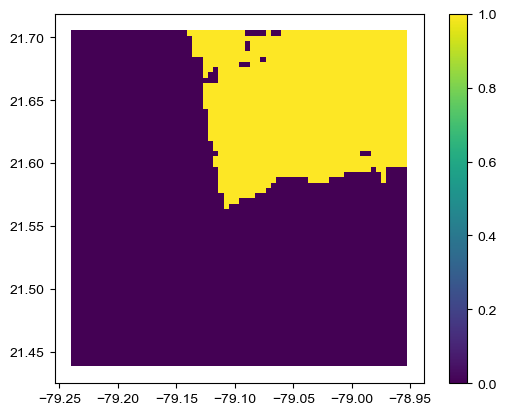

count    4096.000000
mean        0.266113
std         0.441978
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: exclusion_mask, dtype: float64

In [72]:
# check if it looks right
get_exclusion_mask(event, subregion, recalculate=True)
event_gdf = gpd.read_file(join(wd, f"{storm}_{region}", f"feature_stats_{subregion}.gpkg"))
event_gdf.plot('exclusion_mask', legend=True)
plt.show()
event_gdf.exclusion_mask.describe()

In [76]:
from viz_utils import 

<AxesSubplot: >

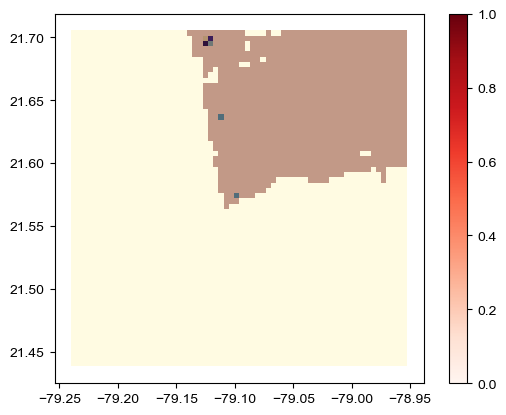

In [80]:
fig, ax = plt.subplots()

event_gdf.plot('floodfrac', cmap="YlGnBu", ax=ax)
event_gdf.plot('exclusion_mask', cmap="Reds", legend=True, alpha=0.4, ax=ax)

<AxesSubplot: >

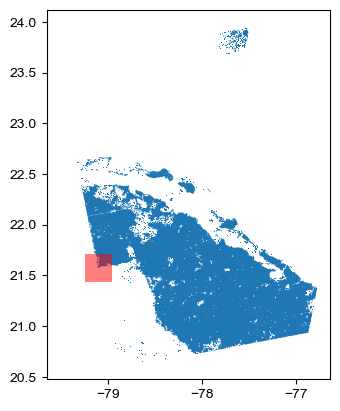

In [54]:
exclusion_mask = gpd.read_file(join(self.wd, f"{event.storm}_{event.region}", "exclusion_mask.gpkg"))

ax = exclusion_mask.plot()
event.feature_gdf[0].plot(ax=ax, color='red', alpha=0.5)

In [60]:
event.feature_gdf[0].exclusion_mask[0]

''

<AxesSubplot: >

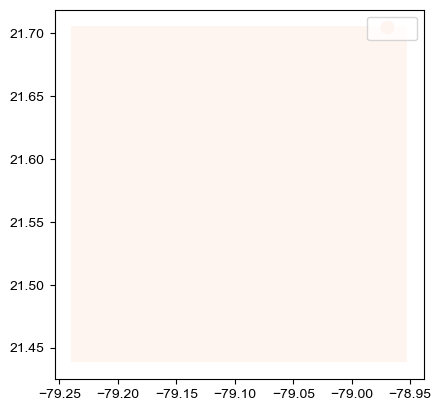

In [58]:
event.feature_gdf[0].plot('exclusion_mask', categorical=False, cmap="Reds", legend=True)

# Try and load a GFM dataset

In [4]:
# event
storm = "ian"
region = "cuba"
nsubregions = 17
subregion = 0

In [7]:
# load event GeoDataFrame (as when getting data)
event = Event(storm, region, nsubregions, wd, bd)
event.make_grids()
event.get_all_features(subregion)

100%|████████████████████████████████████| 4096/4096 [00:00<00:00, 19625.48it/s]
ian_cuba_0: error adding extra flood info:
"['det_method', 'obj_desc'] not in index"
Creating empty fields
Error for mslp for ian, cuba, 0:Image.reduceRegions: Need 1 bands for Reducer.mean, image has 0.
Creating empty field.
Error for sp for ian, cuba, 0:Image.reduceRegions: Need 1 bands for Reducer.mean, image has 0.
Creating empty field.
Error for u10_u for ian, cuba, 0:Image.reduceRegions: Need 1 bands for Reducer.mean, image has 0.
Creating empty field.
Error for u10_v for ian, cuba, 0:Image.reduceRegions: Need 1 bands for Reducer.mean, image has 0.
Creating empty field.
Error for soiltemp1 for ian, cuba, 0:Image.clip: Parameter 'input' is required.
Creating empty field.
Error for soiltemp2 for ian, cuba, 0:Image.clip: Parameter 'input' is required.
Creating empty field.
100%|████████████████████████████████████| 4096/4096 [00:00<00:00, 23589.29it/s]


In [8]:
feature_gdf = event.feature_gdf[subregion]

<AxesSubplot:>

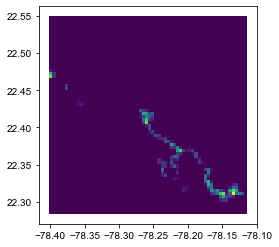

In [13]:
feature_gdf.plot('floodfrac')

In [14]:
event.process_all_subregions()

Creating empty field.
Creating empty field.
ERROR:fiona._env:./../data/ian_cuba/feature_stats_1.gpkg: No such file or directory
100%|████████████████████████████████████| 4096/4096 [00:00<00:00, 19082.40it/s]
"['det_method', 'obj_desc'] not in index"
Creating empty fields
Creating empty field.
Creating empty field.
Creating empty field.
Creating empty field.


KeyboardInterrupt: 

# Get vegetation and JRC layers (without gridding)

In [30]:
def get_ndvi(self, subregion, recalculate=False):
    """NDVI (reprojected and masked from mangroves)"""

    if self.feature_gdf[subregion] is None: self.get_gdf(subregion)

    self.logger.info("Calculating NDVI...")

    try:
        # set up Google Earth Engine for subregion
        if self.connected_to_gee != subregion: self.start_gee(subregion)
        aoi_ee = self.aoi_ee[subregion]
        grid_ee = self.grid_ee[subregion]

        # NDVI
        ndvi = ee.Image(ee.ImageCollection("MODIS/006/MOD13Q1")
                        .filterBounds(aoi_ee)
                        .filterDate(ee.Date(self.startdate).advance(-2, 'month'), ee.Date(self.enddate))
                        .mean()
                        .clip(aoi_ee))

        ndvi = ndvi.select('NDVI')
        ndvi = ndvi.unmask(0)

    except Exception as e:
        print("Didn't work")

    return(ndvi)



def get_permwater(self, band, subregion, recalculate=False):
    """Get JRC Permanent water from Google Earth Engine.

    JRC permanent water dataset: 30 arcseconds (approx. 1km). Needs a better way to impute missing ocean values.
    """
    if self.feature_gdf[subregion] is None: self.get_gdf(subregion)

    
    self.logger.info("Recalculating permanent water...")

    try:
        if self.connected_to_gee != subregion:
            self.start_gee(subregion)

        aoi_ee = self.aoi_ee[subregion]
        grid_ee = self.grid_ee[subregion]

        jrc_permwater = (ee.Image("JRC/GSW1_3/GlobalSurfaceWater")
                         .clip(aoi_ee)
                         .select(band)
                         .unmask(0))

    except Exception as e:
        print("Didn't work")
    
    return jrc_permwater


def get_lulc(self, subregion, recalculate=False):
    """Land use and land cover."""

    if self.feature_gdf[subregion] is None: self.get_gdf(subregion)


    # set up Google Earth Engine for subregion
    if self.connected_to_gee != subregion: self.start_gee(subregion)
    aoi_ee = self.aoi_ee[subregion]
    grid_ee = self.grid_ee[subregion]

    self.logger.info(f"Calculating dominant LULC type per grid cell...")
    try:
        lulc = ee.Image(ee.ImageCollection("ESA/WorldCover/v100")
                          .filterBounds(aoi_ee)
                          .mode()
                          .clip(aoi_ee)
                          .unmask(0))

    except Exception as e:
        print("Didn't work")

    # save output
    return lulc

In [36]:
for subregion in range(nsubregions):
#     ndvi = get_ndvi(event, subregion)

#     # define path to assets to download file
#     assexport_drive = ee.batch.Export.image.toDrive(ndvi,
#                                                     description=f'NDVI_{storm}_{region}_{subregion}',
#                                                     folder=f"{storm}_{region}_{subregion}",
#                                                     fileNamePrefix=f"NDVI_{subregion}",
#                                                     scale=10,
#                                                     maxPixels=1e9)

#     # export to google earth engine account
#     assexport_drive.start()

#     while (assexport_drive.status()['state'] == 'RUNNING') or (assexport_drive.status()['state'] == 'READY'):
#         print('Still running...')
#         time.sleep(10)

#     print("Finished!")

#     jrc_permwater = get_permwater(event, 'occurence', subregion)

#     # define path to assets to download file
#     assexport_drive = ee.batch.Export.image.toDrive(jrc_permwater,
#                                                     description=f'JRC_{storm}_{region}_{subregion}',
#                                                     folder=f"{storm}_{region}_{subregion}",
#                                                     fileNamePrefix=f"JRC_PW_{subregion}",
#                                                     scale=10,
#                                                     maxPixels=1e9)

#     # export to google earth engine account
#     assexport_drive.start()

#     while (assexport_drive.status()['state'] == 'RUNNING') or (assexport_drive.status()['state'] == 'READY'):
#         print('Still running...')
#         time.sleep(10)

#     print("Finished!")
    
    jrc_permwater = get_permwater(event, 'seasonality', subregion)

    # define path to assets to download file
    assexport_drive = ee.batch.Export.image.toDrive(jrc_permwater,
                                                    description=f'JRC_{storm}_{region}_{subregion}',
                                                    folder=f"{storm}_{region}_{subregion}",
                                                    fileNamePrefix=f"JRC_PW_seasonal_{subregion}",
                                                    scale=10,
                                                    maxPixels=1e9)

    # export to google earth engine account
    assexport_drive.start()

    while (assexport_drive.status()['state'] == 'RUNNING') or (assexport_drive.status()['state'] == 'READY'):
        print('Still running...')
        time.sleep(10)

    print("Finished!")
    
    
    lulc = get_lulc(event, subregion)

    # define path to assets to download file
    assexport_drive = ee.batch.Export.image.toDrive(lulc,
                                                    description=f'LULC_{storm}_{region}_{subregion}',
                                                    folder=f"{storm}_{region}_{subregion}",
                                                    fileNamePrefix=f"LULC_{subregion}",
                                                    scale=10,
                                                    maxPixels=1e9)

    # export to google earth engine account
    assexport_drive.start()

    while (assexport_drive.status()['state'] == 'RUNNING') or (assexport_drive.status()['state'] == 'READY'):
        print('Still running...')
        time.sleep(10)

    print("Finished!")


Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Finished!
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Finished!


In [33]:
assexport_drive.status()

{'state': 'COMPLETED',
 'description': 'LULC_batsirai_mananjary_0',
 'creation_timestamp_ms': 1665674686433,
 'update_timestamp_ms': 1665675016331,
 'start_timestamp_ms': 1665674824232,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1N1z1O4LZcd3iagr5Au3wEQBESOQvUsuz'],
 'attempt': 1,
 'id': 'XDBR7XPJ62ZRTO6N36ZYHFC5',
 'name': 'projects/earthengine-legacy/operations/XDBR7XPJ62ZRTO6N36ZYHFC5'}

# Auxilliary spatial features

In [4]:
# features along shortest line to permanent water
from data_utils import features_to_process
event.add_intermediates_to_event(subregion, features_to_process, thresh=pwater_thresh)
line_gdf.replace(np.nan, 0.0).plot('ndvi_to_pw', cmap='YlGn', legend=True)

100%|██████████████████████████████████████| 1833/1833 [00:06<00:00, 281.72it/s]


# Deltares Flood Hazard Maps

In [ ]:
def get_deltares(self, subregion, recalculate=False):
    """Download Deltares flood data.

    Deltares coastal flood hazard data.
    """
    if self.feature_gdf[subregion] is None: self.get_gdf(subregion)

    # get data from GEE
    if "deltares" not in self.feature_gdf[subregion] or recalculate:
        feature_gdf = self.feature_gdf[subregion]

        try:
            if self.connected_to_gee != subregion:
                self.start_gee(subregion)

            # cycle through all rps
            rp = 100
            slr = 2018
            minx, miny, maxx, maxy = feature_gdf.unary_union.bounds

            # load deltares data
            client = dask.distributed.Client(processes=False)
            catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1/")
            search = catalog.search(
                collections=["deltares-floods"],
                query={
                    "deltares:dem_name": {"eq": "NASADEM"},
                    "deltares:sea_level_year": {"eq": slr},
                    "deltares:return_period": {"eq": rp},
                },
            )
            item = next(search.get_items())
            url = item.assets["index"].href
            ds = xr.open_dataset(f"reference::{url}", engine="zarr", consolidated=False, chunks={})
            ds_aoi = ds.sel(lat=slice(miny, maxy), lon=slice(minx, maxx), time=ds.time[0])
            flooded = ds_aoi.inun.where(ds_aoi.inun > 0, 0)
            flooded = flooded.where(flooded==0, 1)
            flooded.rio.set_crs('epsg:4326');

            # convert to src and overlay to feature stats grid
            flooded.rio.to_raster('src_temp.tiff')
            src = rasterio.open('src_temp.tiff')
            remove('src_temp.tiff')

            feature_gen = rasterio.features.dataset_features(src, geographic=True, as_mask=True)
            feature_list = [feature for feature in feature_gen]
            geom = [shape(i['geometry']) for i in feature_list]
            values = [i['properties']['val'] for i in feature_list]
            flood_gdf = gpd.GeoDataFrame({'geometry':geom}).set_crs(4326)

            feature_gdf = data_utils.get_grid_intersects(flood_gdf, feature_gdf, floodcol='deltares')

        except Exception as e:
            self.logger.error(f"Error for Deltares data for {self.storm}, {self.region}, {subregion}:"\
                                f"\n{e}\n\nCreating empty fields.")
            feature_gdf["deltares"] = [""] * len(feature_gdf)

        self.feature_gdf[subregion] = feature_gdf
        #self.save_gdf(subregion)

In [10]:
get_deltares(event, subregion)
event_gdf = event.feature_gdf[subregion]

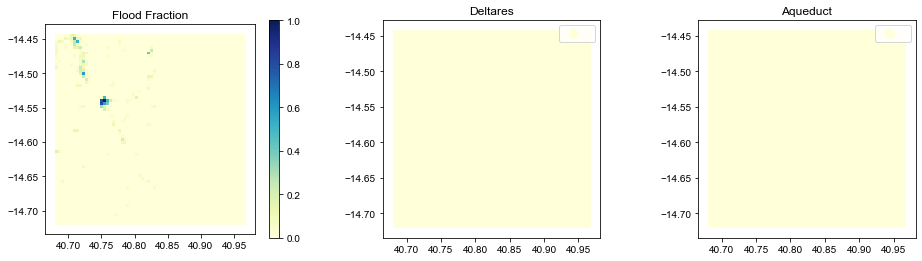

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
event_gdf.plot('floodfrac', ax=ax[0], legend=True, cmap='YlGnBu')
event_gdf.plot('deltares', ax=ax[1], legend=True, cmap='YlGnBu')
event_gdf.plot('aqueduct', ax=ax[2], legend=True, cmap='YlGnBu')

ax[0].set_title('Flood Fraction')
ax[1].set_title('Deltares')
ax[2].set_title('Aqueduct');